In [1]:
import sys
print(sys.version)

3.8.5 | packaged by conda-forge | (default, Sep 24 2020, 16:37:41) 
[Clang 10.0.1 ]


# Model Evaluation 
Name: Andrew Auyeung  
Location: 'lib/model_eval.ipynb'  

Target metrics for prediction of rain is centered around recall 

Version 1: Models trained on Base Weather Station Data  
Version 2: Models trained on Base Weather Station Data with Hurricane/Storm Data.    
Models will add class weight parameters added into the gridsearch for logisticregression and randomforest.   
Version 3: Ensemble Stacking of Models

In [31]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

In [3]:
# Open models from Version 1 
knn = pickle.load(open('../models/Version 1/knn.pickle', 'rb'))
logreg = pickle.load(open('../models/Version 1/logreg.pickle', 'rb'))
rf = pickle.load(open('../models/Version 1/rf.pickle', 'rb'))
xgb = pickle.load(open('../models/Version 1/xgb.pickle', 'rb'))
baseline = pickle.load(open('../models/Version 1/baseline.pickle', 'rb'))
test_holdout = pickle.load(open('../models/Version 1/test_holdout.pickle', 'rb'))

In [4]:
X_test = test_holdout['X_test']
y_test = test_holdout['y_test']
X_holdout = test_holdout['X_holdout']
y_holdout = test_holdout['y_holdout']

In [22]:
# Predict Proba from X_test 
knn_proba = knn.predict_proba(X_test)
logreg_proba = logreg.predict_proba(X_test)
rf_proba = rf.predict_proba(X_test)
xgb_proba = xgb.predict_proba(X_test)

# Base Predictions
knn_preds = knn.predict(X_test)
logreg_preds = logreg.predict(X_test)
rf_preds = rf.predict(X_test)
xgb_preds = xgb.predict(X_test)

preds = ['knn_preds', 'logreg_preds', 'rf_preds', 'xgb_preds']


In [50]:
rf.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 12,
 'min_samples_split': 10,
 'n_estimators': 450}

In [52]:
# Classification Reports
for model in preds: 
    print(model[:-6]+' Confusion Matrix')
    print(confusion_matrix(y_test, eval(model)))
    print('\n'+model[:-6]+' Classification Report')
    print(classification_report(y_test, eval(model)))
    

knn Confusion Matrix
[[1323 1025]
 [ 425  712]]

knn Classification Report
              precision    recall  f1-score   support

           0       0.76      0.56      0.65      2348
           1       0.41      0.63      0.50      1137

    accuracy                           0.58      3485
   macro avg       0.58      0.59      0.57      3485
weighted avg       0.64      0.58      0.60      3485

logreg Confusion Matrix
[[1377  971]
 [ 425  712]]

logreg Classification Report
              precision    recall  f1-score   support

           0       0.76      0.59      0.66      2348
           1       0.42      0.63      0.50      1137

    accuracy                           0.60      3485
   macro avg       0.59      0.61      0.58      3485
weighted avg       0.65      0.60      0.61      3485

rf Confusion Matrix
[[2017  331]
 [ 764  373]]

rf Classification Report
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      2348
        

From the Classification Reports, the KNearestNeighbors Classifier has the best recall.  On days that it does rain, the model correctly predicts rain 68% of the time.  XGBoost had the highest precision where 67% of the days it predicted rain, it was correct.  

On predicting days of no rain, Random Forest and XGBoost both perform better.  

In [29]:
knn_proba = knn_proba[:,1]
logreg_proba = logreg_proba[:,1]
rf_proba = rf_proba[:,1]
xgb_proba = xgb_proba[:,1]

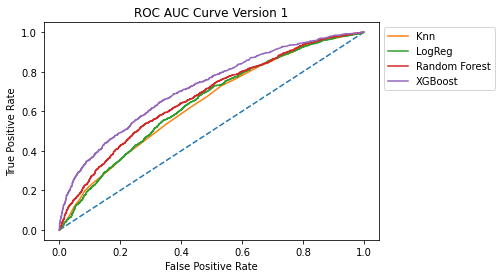

In [33]:
# ROC AUC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba, pos_label=1)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_proba, pos_label=1)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba, pos_label=1)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba, pos_label=1)
x_ = np.linspace(0, 1, 1000)
y_ = x_
plt.plot(x_, y_, '--')
plt.plot(fpr_knn, tpr_knn, label='Knn')
plt.plot(fpr_logreg, tpr_logreg, label='LogReg')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(bbox_to_anchor=(1,1))
plt.title('ROC AUC Curve Version 1');

XGBoost outperforms the other models in terms of ROC. 
Potential threshold is 0.4. 

<AxesSubplot:xlabel='param_knn__n_neighbors', ylabel='mean_test_score'>

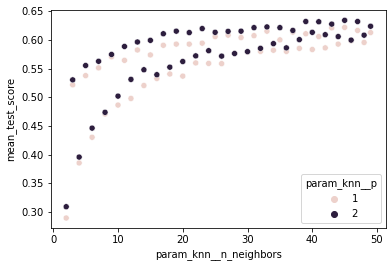

In [61]:
knn_df = pd.DataFrame(knn.cv_results_)
sns.scatterplot(x='param_knn__n_neighbors', y='mean_test_score', data=knn_df, hue='param_knn__p')

In [62]:
knn_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.211671,0.006030,0.570855,0.010221,2,1,"{'knn__n_neighbors': 2, 'knn__p': 1}",0.301230,0.290984,0.278689,0.282787,0.295082,0.289754,0.008156,96
1,0.189394,0.014159,0.402148,0.009666,2,2,"{'knn__n_neighbors': 2, 'knn__p': 2}",0.313525,0.309426,0.301230,0.307377,0.315574,0.309426,0.005019,95
2,0.189896,0.005060,0.575634,0.007283,3,1,"{'knn__n_neighbors': 3, 'knn__p': 1}",0.510246,0.536885,0.493852,0.506148,0.561475,0.521721,0.024336,84
3,0.183390,0.006235,0.431126,0.015646,3,2,"{'knn__n_neighbors': 3, 'knn__p': 2}",0.528689,0.561475,0.487705,0.500000,0.573770,0.530328,0.033456,83
4,0.188340,0.005700,0.595314,0.009898,4,1,"{'knn__n_neighbors': 4, 'knn__p': 1}",0.385246,0.399590,0.370902,0.370902,0.401639,0.385656,0.013305,94


<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

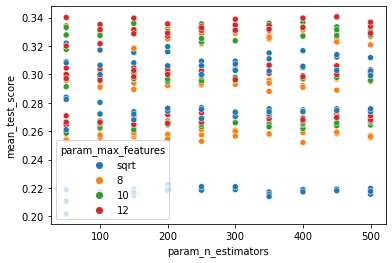

In [68]:
rf_df = pd.DataFrame(rf.cv_results_)
sns.scatterplot(x='param_n_estimators', y='mean_test_score', data=rf_df, hue='param_max_features')

In [67]:
rf_df.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
348,19.186871,0.150038,0.211793,0.003434,gini,None,12,10,450,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.368852,0.331967,0.329918,0.375000,0.299180,0.340984,0.027875,1
358,18.003068,0.229613,0.192191,0.013055,gini,None,12,20,450,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.364754,0.342213,0.325820,0.372951,0.297131,0.340574,0.027352,2
338,20.085374,0.242096,0.226870,0.018406,gini,None,12,2,450,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.360656,0.331967,0.321721,0.383197,0.305328,0.340574,0.027899,3
340,2.163769,0.025856,0.029204,0.000709,gini,None,12,10,50,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.352459,0.334016,0.331967,0.366803,0.315574,0.340164,0.017723,4
337,17.850879,0.153669,0.194992,0.003697,gini,None,12,2,400,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.362705,0.325820,0.323770,0.385246,0.301230,0.339754,0.030100,5
347,17.174404,0.126437,0.185693,0.001810,gini,None,12,10,400,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.362705,0.325820,0.331967,0.366803,0.311475,0.339754,0.021508,5
342,6.433042,0.071830,0.072772,0.003116,gini,None,12,10,150,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.358607,0.348361,0.334016,0.360656,0.297131,0.339754,0.023307,5
345,12.972009,0.072180,0.143279,0.004773,gini,None,12,10,300,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.364754,0.331967,0.323770,0.372951,0.301230,0.338934,0.026548,8
307,15.193323,0.117533,0.197440,0.003814,gini,None,10,2,400,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.356557,0.336066,0.313525,0.375000,0.303279,0.336885,0.026516,9
349,21.470049,0.238501,0.235468,0.010073,gini,None,12,10,500,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.360656,0.317623,0.325820,0.381148,0.299180,0.336885,0.029797,10
